### Load libraries

In [1]:
# systemic libraries
import os 
import sys
import tempfile
import warnings
from datetime import date

# single-cell and data-wrangling 
import scanpy as sc 
import pandas as pd 
import numpy as np 
import numba as nb
import anndata as ad
import leidenalg
import scanpy.external as sce
import harmonypy
import decoupler

# visualization
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns

<i><b> Print the container version </b></i>

In [2]:
# Container used for this analysis can be found here : cokorac/cs-core-image-amd64:dev
day = date.today()
print('The last use of the container:', day)

The last use of the container: 2025-03-26


<i><b> Set the home directory </b></i>

In [3]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

<i><b> Set the container image </b></i>

In [4]:
with open("/image_version", "r") as f:
    image_name = f.readline().replace("\n", "")
image_name

'sddcunit/downstream:sc-1.1.0'

### Load the data

In [5]:
# Load the individual datasets to extract sample_id information
adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad")

In [ ]:
# Subset to classes of interest 
#adata_ss = adata[adata.obs['FAM107A_and_HOPX_and_TNC_positive'].isin(['fam107a_and_hopx_and_tnc_positive'])]
#adata_ss

In [ ]:
# Create the species column 
#adata_ss.obs['species'] = ''
#adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Ruan'] = 'mouse_Ncx'
#adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Zylka'] = 'mouse_Ncx'
#adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Linnarsson'] = 'mouse_DG'
#adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Polioudakis'] = 'human_Ncx'
#adata_ss.obs['species'].loc[adata_ss.obs['dataset_of_origin'] == 'Trevino'] = 'human_Ncx'

### Data integration

In [ ]:
# Define paths
adata_file = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration"
harmony_script_path = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration/integration_script.py"
sbatch_script_path = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration/run_integration.job"

In [ ]:
# Write the integration script 
integration_script = f"""
import os 
import sys
import tempfile
import warnings
from datetime import date

# single-cell and data-wrangling 
import scanpy as sc 
import pandas as pd 
import numpy as np 
import numba as nb
import anndata as ad
import leidenalg
import scanpy.external as sce
import harmonypy

# Load the data
adata_name = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad"
adata = sc.read_h5ad(adata_name)

# Select the layer
adata.X = adata.layers['log_normalized_scaled_counts'].copy()

# Calculate the PCA 
sc. .pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack', random_state = 111)

# Run harmony
sce.pp.harmony_integrate(adata, key = 'dataset_of_origin', adjusted_basis='X_pca_harmony',
                         max_iter_harmony = 30)

# Save the data
adata.write_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_integrated.h5ad")

"""
with open(harmony_script_path, "w") as f:
    f.write(integration_script)

In [ ]:
# Write the bash script
sbatch_script = f"""#!/bin/bash
#SBATCH --time=24:00:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --gres=gpu:1
#SBATCH --partition=gpuq
#SBATCH --job-name=integration
#SBATCH --mem=64GB
#SBATCH --mail-type=END
#SBATCH --output=%x_%j.log

export SINGULARITY_CACHEDIR=/group/kalebic/Nikola/1_single_cell_final/Nikola_final/scmorpho/.singularity/
export SINGULARITY_TMPDIR=$TMPDIR

module load cuda11.1/toolkit/11.1.1
module load singularity
singularity exec --nv -H {home_path} \\
                 docker://{image_name} \\
                 python3 {os.path.abspath(harmony_script_path)}

"""

with open(sbatch_script_path, "w") as f:   
    f.write(sbatch_script)

### Neighboring and clustering

In [5]:
# Load the integrated data
adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_integrated.h5ad")
adata

AnnData object with n_obs × n_vars = 113667 × 10801
    obs: 'sample_id', 'dataset_of_origin', 'leiden', 'FAM107A_and_HOPX_and_TNC_positive', 'HOPX_and_TNC_positive'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dataset_of_origin_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log_normalized_counts', 'log_normalized_scaled_counts', 'normalized_counts'
    obsp: 'connectivities', 'distances'

In [6]:
# Compute the kNN graph
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=30, n_neighbors=80, random_state = 111)

2025-03-26 13:52:39.856288: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 13:52:42.152122: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 13:52:44.434196: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-26 13:52:44.434240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-26 13:52:44.437503: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'dataset_of_origin'}, xlabel='UMAP1', ylabel='UMAP2'>

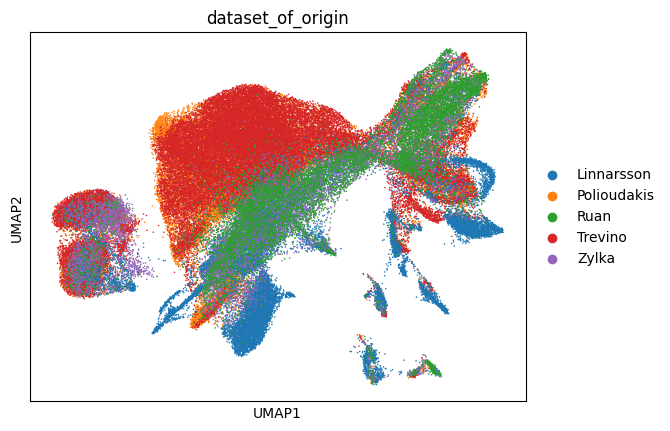

In [7]:
# Plot UMAPs
sc.tl.umap(adata, random_state = 111)
sc.pl.umap(adata, color=["dataset_of_origin"], size = 5, frameon=True, show = False)

In [8]:
adata

AnnData object with n_obs × n_vars = 113667 × 10801
    obs: 'sample_id', 'dataset_of_origin', 'leiden', 'FAM107A_and_HOPX_and_TNC_positive', 'HOPX_and_TNC_positive'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dataset_of_origin_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log_normalized_counts', 'log_normalized_scaled_counts', 'normalized_counts'
    obsp: 'connectivities', 'distances'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'Cluster annotation')

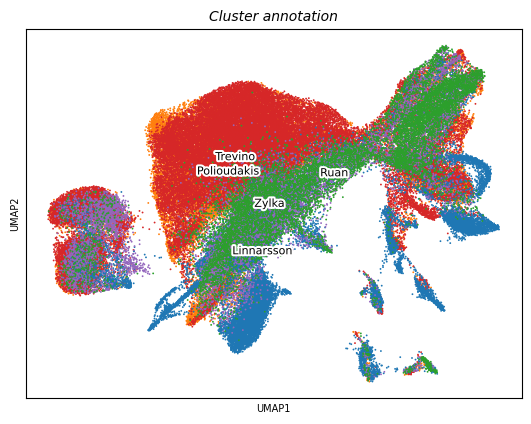

In [12]:
# Plot the UMAP
ax=sc.pl.umap(adata, color=['dataset_of_origin'], show=False, frameon=True, legend_loc = "on data",
              legend_fontsize=8, size =7, legend_fontweight=3, ncols = 1, legend_fontoutline = 3, title = '')

# Modify labels
ax.set_xlabel('UMAP1',fontsize=7)
ax.set_ylabel('UMAP2',fontsize=7)
ax.set_title('Cluster annotation', style='italic', fontsize = 10)

In [ ]:
# Compute clusters
sc.tl.leiden(adata, key_added="X_leiden_harmony", resolution=0.60, random_state = 100)
sc.pl.umap(adata, color="X_leiden_harmony", frameon=True, size = 5)

### DGE analysis

In [ ]:
# Select raw counts
adata_ss.X = adata_ss.layers['counts'].copy()
# Round the raw counts
adata_ss.X = np.round(adata_ss.X)
# Print the raw counts layer
adata_ss.X

In [ ]:
# Generate pseudobulk replicates
pdata = decoupler.get_pseudobulk(
    adata_ss,
    sample_col='sample_id',
    groups_col= ['species', 'dataset_of_origin'],
    layer='counts',
    mode= 'sum',
    min_cells=0,
    min_counts=0, 
)

In [ ]:
# Plot the pseudobulk replicates
decoupler.plot_psbulk_samples(pdata, groupby='species', figsize=(4, 3), dpi = 80)

In [ ]:
# Re-generate pseudobulk replicates
pdata = decoupler.get_pseudobulk(
    adata_ss,
    sample_col='sample_id',
    groups_col= ['species', 'dataset_of_origin'],
    layer='counts',
    mode= 'sum',
    min_cells=3,
    min_counts=0, 
)

In [ ]:
# Re-plot the pseudobulk replicates
decoupler.plot_psbulk_samples(pdata, groupby='species', figsize=(4, 3), dpi = 80)

In [ ]:
# Subset to species of interest 
pdata_ss = pdata[pdata.obs['species'].isin(['human_Ncx', 'mouse_DG'])]
pdata_ss

In [ ]:
# Switch to raw counts
pdata_ss.layers['counts'] = pdata_ss.X
pdata_ss.X = pdata_ss.layers['counts'].copy()

In [ ]:
# Normalize, scale and compute pca
sc.pp.normalize_total(pdata_ss, target_sum=1e6, exclude_highly_expressed=True) #CPM
pdata_ss.layers['normalized'] = pdata_ss.X.copy()
sc.pp.log1p(pdata_ss)
pdata_ss.layers['log-normalized'] = pdata_ss.X.copy()
sc.pp.highly_variable_genes(pdata_ss, subset=False)
sc.pp.scale(pdata_ss, max_value=10)
pdata_ss.layers['log-normalized-scaled'] = pdata_ss.X.copy()

In [ ]:
# Switch to normalized counts
pdata_ss.X = pdata_ss.layers['normalized'].copy()

In [ ]:
decoupler.plot_filter_by_expr(pdata_ss, group='species', min_count=10, min_total_count= 100, 
                              min_prop = 0.7, figsize = (5, 4), dpi = 80)

In [ ]:
# Keep only sufficiently abundant genes
genes = decoupler.filter_by_expr(pdata_ss, group='species', min_count=10, min_total_count=100)
pdata_2 = pdata_ss[:, genes].copy()

In [ ]:
# Switch back to raw counts
pdata_2.X = np.round(pdata_2.layers['counts']).astype(int).copy()
pdata_2.X

In [ ]:
# Prepare the deseq2 format
dds_bRG_Ncx_DG = DeseqDataSet(
    adata = pdata_2,    
    design_factors= ['species'],
    ref_level=['species', 'human_Ncx'],
    refit_cooks=True)

In [ ]:
# Run deseq2
dds_bRG_Ncx_DG.deseq2()

In [ ]:
# Extract the results
stat_res = DeseqStats(
    dds_bRG_Ncx_DG, 
    contrast=['species', 'human-Ncx', 'mouse-DG'])
stat_res.summary()

In [ ]:
# Save as dataframe
results_bRG_Ncx_DG = stat_res.results_df

In [ ]:
# Reindex the dataframe
results_bRG_Ncx_DG_2 = results_bRG_Ncx_DG.copy()
results_bRG_Ncx_DG_2.reset_index(inplace=True)
results_bRG_Ncx_DG_2.rename(columns ={'index':'gene_name'}, inplace = True)

In [ ]:
# Plot
sc.set_figure_params(dpi_save = 300, dpi = 80)
volcano(results_bRG_Ncx_DG_2, pvalue = 'padj', log2fc = 'log2FoldChange', symbol = 'gene_name', 
        pval_thresh = 0.05, to_label = 20, fontsize = 7, log2fc_thresh = 1, colors = ['#cb181d', '#636363', '#41ab5d'], save = '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/degs/hNCX_mDG_degs')

In [ ]:
DEGs = results_bRG_Ncx_DG_2[results_bRG_Ncx_DG_2['padj'] < 0.05]

degs_up = DEGs[DEGs['log2FoldChange'] > 1]
degs_down = DEGs[DEGs['log2FoldChange'] < -1]

In [ ]:
print(len(degs_up))
print(len(degs_down))